# Module 2 Project

The business case that I would like to address with this project is fairly simple.  My goal is to build a model that will allow me to recommend the ideal geographic location to a home buyer, maximizing cost effectiveness.  In order to accomplish this there are a few key questions I will need to answer.

> - What is the most cost effective location in King County?
> - How much money can be saved based solely on location?
> - Are there any other savings opportunities hidden in the data? 

The first question will likely comprise the bulk of my work. Providing an answer here will require using all of the geographical data available in the data set, as well as creating new variables and employing some creativity.  Once the first question is answered the second should be simple to solve based on the information already gathered.  The final question should also be answered along the way.  

In [1]:
#Importing all necessary packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Cleaning and Exploration

In [2]:
#Importing the data into a dataframe and taking a first look at it
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#More detailed view of the data
for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize = True).head(), '\n\n')

id 
 795000620     0.000139
1825069031    0.000093
2019200220    0.000093
7129304540    0.000093
1781500435    0.000093
Name: id, dtype: float64 


date 
 6/23/2014    0.006575
6/26/2014    0.006066
6/25/2014    0.006066
7/8/2014     0.005880
4/27/2015    0.005834
Name: date, dtype: float64 


price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64 


bedrooms 
 3    0.454878
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64 


sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
7500    0.005510
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.494189
2.0    0.381303
1.5    

In [4]:
#Creating a list of continuous and categorical variables
cats = []
conts = []

for col in df.columns:
    if df[col].nunique() <= 75:
        cats.append(col)
    else:
        conts.append(col)
print(cats)
print(conts)

['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_renovated', 'zipcode']
['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


,id,price,sqft_living,sqft_lot,sqft_above,yr_built,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,2080.321850,1.509941e+04,1788.596842,1970.999676,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,918.106125,4.141264e+04,827.759761,29.375234,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,370.000000,5.200000e+02,370.000000,1900.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,1430.000000,5.040000e+03,1190.000000,1951.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,1910.000000,7.618000e+03,1560.000000,1975.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,2550.000000,1.068500e+04,2210.000000,1997.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,13540.000000,1.651359e+06,9410.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


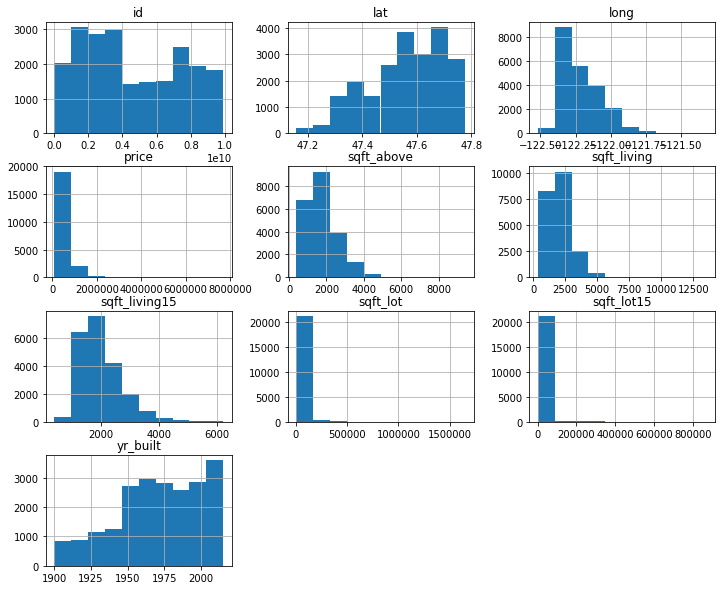

In [5]:
#Description of all columns
#Histogram of the continuous variables to check distributions
df_conts = df.loc[:,conts]
df_conts.hist(figsize=(12,10))
df_conts.describe()

In [6]:
#Checking all of the columns for NaN values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
#After looking at where the NaN values are located
#there should be no problem replacing them with zero
df = df.fillna(0)

In [8]:
#Changing the date column into datetime format
df['date'] = pd.to_datetime(df['date'])

# Creating New Variables

In [9]:
#Creating a list of zip codes and rank them by average price
zip_df = df.groupby(by = 'zipcode').mean()
zip_ordered = zip_df.sort_values(by=['price'])
zip_list = zip_ordered.index.tolist()
#Splitting the list into 10 zip groups
zip_groups = np.array_split(zip_list, 10)
print(zip_groups[0])

[98002 98168 98032 98001 98148 98023 98188]


In [10]:
#Creating a new column containing the zip group
#Assign a value based on the zip code's position in the ranking
df['zip_group'] = 0
data_range = range(0, len(df.index))
n_range = range(0, len(zip_groups))

for row in data_range:
    for n in n_range:
        if df.loc[row, 'zipcode'] in zip_groups[n]:
            df.loc[row, 'zip_group'] = n

In [11]:
#Creating a 'true_age' column 
#This will contain the number of years since the house was either built or renovated
df['true_age'] = 0
for row in data_range:
    if df.loc[row, 'yr_renovated'] != 0:
        df.loc[row, 'true_age'] = df.loc[row, 'yr_renovated']
    else:
        df.loc[row, 'true_age'] = df.loc[row, 'yr_built']
df['true_age'] = 2020 - df['true_age']

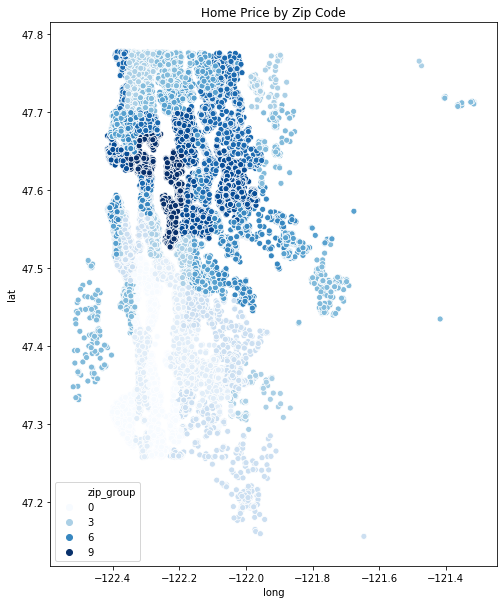

In [12]:
#Visualizing the zip code data to see if there is an obvious epicenter
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', hue='zip_group', data=df, palette='Blues')
plt.title('Home Price by Zip Code')
plt.legend(fancybox=True);

In [13]:
#Based on the above visualization, I estimated an epicenter where prices seemed highest
#I then used 'lat' and 'long' to calculate the distance between this point and each home
lat_zero = 47.617
long_zero = -122.250
df['lat_delta'] = df['lat'] - lat_zero
df['long_delta'] = df['long'] - long_zero
df['distance'] = (df['lat_delta']**2 + df['long_delta']**2)**.5
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,zip_group,true_age,lat_delta,long_delta,distance
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,98178,47.5112,-122.257,1340,5650,1,65.0,-0.1058,-0.007,0.106031
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,98125,47.7210,-122.319,1690,7639,4,29.0,0.1040,-0.069,0.124808
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,98028,47.7379,-122.233,2720,8062,4,87.0,0.1209,0.017,0.122089
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,98136,47.5208,-122.393,1360,5000,5,55.0,-0.0962,-0.143,0.172347
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,98074,47.6168,-122.045,1800,7503,8,33.0,-0.0002,0.205,0.205000


In [14]:
#Creating a month column so that it can be separated into seasons
df['month'] = 0
for row in data_range:
    df.loc[row, 'month'] = df.loc[row, 'date'].month

In [15]:
#Dividing months into seasons with a list
#Creating a season column so that I can make dummy variables
season_months = [[3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 1, 2]]
df['season'] = 0
n_range = range(0, len(season_months))

for row in data_range:
    for n in n_range:
        if df.loc[row, 'month'] in season_months[n]:
            df.loc[row, 'season'] = n

In [16]:
#Creating dummy variables for the seasons and storing them in a dataframe
season_df = pd.get_dummies(df['season'], prefix='s', drop_first=True)
season_df = season_df.rename(columns={"s_1": "summer", "s_2": "autumn", "s_3": "winter"})
season_df.head()

,summer,autumn,winter
0,0,1,0
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [17]:
#Concatenating the main dataframe with the season dummy variables
new_df = pd.concat([df, season_df], axis=1)
new_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zip_group,true_age,lat_delta,long_delta,distance,month,season,summer,autumn,winter
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1,65.0,-0.1058,-0.007,0.106031,10,2,0,1,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,4,29.0,0.1040,-0.069,0.124808,12,3,0,0,1
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,4,87.0,0.1209,0.017,0.122089,2,3,0,0,1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,5,55.0,-0.0962,-0.143,0.172347,12,3,0,0,1
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,33.0,-0.0002,0.205,0.205000,2,3,0,0,1


# Cleaning the Combined Data

In [18]:
#Checking for collinearity 
data_pred = new_df.drop(['price', 'date', 'sqft_basement', 'id'], axis=1)
df_test=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_test['pairs'] = list(zip(df_test.level_0, df_test.level_1))
df_test.set_index(['pairs'], inplace = True)
df_test.drop(columns=['level_1', 'level_0'], inplace = True)
df_test.columns = ['cc']
df_test.drop_duplicates(inplace=True)
df_test[(df_test.cc>.75) & (df_test.cc <1)]

,cc
pairs,
"(lat_delta, lat)",1.000000
"(yr_built, true_age)",0.926406
"(sqft_above, sqft_living)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(grade, sqft_above)",0.756073
"(bathrooms, sqft_living)",0.755758


In [19]:
#Dropping columns that exhibited collinearity or are irrelevant
#Dropping columns that show up as outliers (waterfront, view, yr_renovated)
new_df = new_df.drop(['id', 'floors','sqft_living15', 'sqft_above','waterfront', \
                      'view', 'yr_renovated', 'yr_built', 'lat_delta', 'long_delta'], axis=1)
new_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_basement,zipcode,...,long,sqft_lot15,zip_group,true_age,distance,month,season,summer,autumn,winter
0,2014-10-13,221900.0,3,1.00,1180,5650,3,7,0.0,98178,...,-122.257,5650,1,65.0,0.106031,10,2,0,1,0
1,2014-12-09,538000.0,3,2.25,2570,7242,3,7,400.0,98125,...,-122.319,7639,4,29.0,0.124808,12,3,0,0,1
2,2015-02-25,180000.0,2,1.00,770,10000,3,6,0.0,98028,...,-122.233,8062,4,87.0,0.122089,2,3,0,0,1
3,2014-12-09,604000.0,4,3.00,1960,5000,5,7,910.0,98136,...,-122.393,5000,5,55.0,0.172347,12,3,0,0,1
4,2015-02-18,510000.0,3,2.00,1680,8080,3,8,0.0,98074,...,-122.045,7503,8,33.0,0.205000,2,3,0,0,1


In [20]:
#Defining a function that will drop outliers from all numeric columns depending on their z score
def drop_outliers(df, z_score=3):
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_score, result_type='reduce') \
        .all(axis=1)
    df.drop(df.index[~constrains], inplace=True)

In [21]:
#Using function to drop outliers
drop_outliers(new_df)
print(new_df.shape)

(20116, 21)


In [22]:
#Checking to see which variables would be the strongest predictors
pred = new_df.drop(['price', 'lat', 'long', 'date', 'month', 'sqft_basement'], axis=1)

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=6)
selector = selector.fit(pred, new_df['price'])
selector.support_
col_list = pred.columns.tolist()
selector_list = selector.support_.tolist()

selections_list = list(zip(col_list, selector_list))
print(selections_list)

[('bedrooms', True), ('bathrooms', True), ('sqft_living', False), ('sqft_lot', False), ('condition', True), ('grade', True), ('zipcode', False), ('sqft_lot15', False), ('zip_group', True), ('true_age', False), ('distance', True), ('season', False), ('summer', False), ('autumn', False), ('winter', False)]


In [23]:
#making a list of the seasons for easy access later
season_list = ['summer', 'autumn', 'winter']

# Modeling the data

In [24]:
#Choosing features for the model
features_list = ['sqft_living', 'zip_group', 'distance', 'grade', 'true_age'] + season_list
#Creating a model using the chosen features
outcome = 'price'

x_cols = new_df[features_list].columns
predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

model = smf.ols(formula=f, data=new_df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
=============================================================================
Model:                 OLS                 Adj. R-squared:        0.762      
Dependent Variable:    price               AIC:                   528651.2322
Date:                  2020-07-27 09:21    BIC:                   528722.4156
No. Observations:      20116               Log-Likelihood:        -2.6432e+05
Df Model:              8                   F-statistic:           8045.      
Df Residuals:          20107               Prob (F-statistic):    0.00       
R-squared:             0.762               Scale:                 1.5158e+10 
-----------------------------------------------------------------------------
               Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
-----------------------------------------------------------------------------
Intercept   -423164.1349  9619.0077 -43.9925 0.0000 -442018.1785 -404310.0912
sqft_living     129.1562     1.6276  79.3535 0.0000     125.9660     132.3465
zip_group     37142.4492   401.4575  92.5190 0.0000   36355.5596   37929.3387
distance    -429983.3503 12328.7141 -34.8766 0.0000 -454148.6405 -405818.0601
grade         70677.7876  1332.2141  53.0529 0.0000   68066.5389   73289.0364
true_age       1206.5645    36.6277  32.9413 0.0000    1134.7712    1278.3578
summer       -21670.8878  2252.5277  -9.6207 0.0000  -26086.0268  -17255.7488
autumn       -24048.2718  2391.1720 -10.0571 0.0000  -28735.1649  -19361.3787
winter       -19460.1917  2629.1106  -7.4018 0.0000  -24613.4640  -14306.9195
-----------------------------------------------------------------------------
Omnibus:                 6185.140         Durbin-Watson:            1.962    
Prob(Omnibus):           0.000            Jarque-Bera (JB):         30679.383
Skew:                    1.408            Prob(JB):                 0.000    
Kurtosis:                8.355            Condition No.:            32705    
=============================================================================
* The condition number is large (3e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

In [25]:
#Preparing the data in order to perform a train-test split
df_final = new_df[['price'] + features_list]
y = df_final[['price']]
X = df_final.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
print(len(X_train), len(X_test), len(y_train), len(y_test))

16092 4024 16092 4024


In [26]:
#Calculating the mean squared error for the training and test sets
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)

Train Mean Squared Error: price    1.516514e+10
dtype: float64
Test Mean Squared Error: price    1.511082e+10
dtype: float64


# Additional Calculations
Below, I will perform any remaining calculations that are necessary to answer the original business case and create graphs.  Answers will be provided after the graph section.

In [27]:
#Wrote a function to pull coefficients from the summary data
#Optional argument abval returns the absolute value
def find_coef(items, abval=False):
    coef_list = []
    for x in items:
        if abval:
            coef_list.append(abs(model.summary2().tables[1].loc[x, 'Coef.']))
        else:
            coef_list.append(model.summary2().tables[1].loc[x, 'Coef.'])
    return coef_list

In [28]:
#making a function to pull confidence intervals from the summary data
def conf_interval(items):
    interval_list = []
    for x in items:
        lower_bound = model.summary2().tables[1].loc[x, '[0.025']
        upper_bound = model.summary2().tables[1].loc[x, '0.975]']
        interval_list.append(abs(upper_bound - lower_bound)/2)
    return interval_list

In [29]:
#Grouping data so that it can be graphed later on
zip_subset = new_df[new_df['zip_group'] == 0]
grouped_subset = zip_subset.groupby(by = 'zipcode').mean()
comp_subset = new_df[new_df['zip_group'] > 0]
concatenated = pd.concat([zip_subset.assign(dataset='set1'), \
                          comp_subset.assign(dataset='set2')])

In [30]:
#Grouping more data so that it can be graphed later
winner_subset = new_df[new_df['zipcode'] == 98023]
loser_subset = new_df[new_df['zipcode'] != 98023]
concatenated2 = pd.concat([winner_subset.assign(dataset='set1'), \
                          loser_subset.assign(dataset='set2')])

In [31]:
#Grouping more data so that it can be graphed later
real_loser_subset = new_df[new_df['zipcode'] == 98039]
other_subset = new_df[new_df['zipcode'] != 98039]
concatenated3 = pd.concat([real_loser_subset.assign(dataset='set1'), \
                          other_subset.assign(dataset='set2')])

In [32]:
#Preparing a dataframe I can use to test which ZIP code works best for my model
grouped_distance = new_df.groupby(by = 'zipcode').mean()
sorted_distance = grouped_distance.sort_values(by='distance', ascending=False)
distance_coef = find_coef(['distance'])[0]
zip_group_coef = find_coef(['zip_group'])[0]


In [33]:
#Multiplying out the coefficients to find the optimal predicted location
sorted_distance['rating'] = ""
for x in sorted_distance.index:
    z = sorted_distance.loc[x, 'distance'] * distance_coef \
    + sorted_distance.loc[x, 'zip_group'] * zip_group_coef
    sorted_distance.loc[x, 'rating'] = z

In [34]:
#Calculating the maximum difference in price that can be explained by location
max_rating = sorted_distance['rating'].max()
min_rating = sorted_distance['rating'].min()
rating_diff = max_rating - min_rating
print(rating_diff)

466857.3890470745


In [35]:
sorted_distance.sort_values(by='rating', ascending=False).head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,lat,long,sqft_lot15,zip_group,true_age,distance,month,season,summer,autumn,winter,rating
zipcode,,,,,,,,,,,,,,,,,,,
98039,1.217500e+06,3.611111,2.138889,2319.444444,13396.944444,3.666667,7.944444,47.626394,-122.233000,14508.666667,9.0,56.722222,0.020994,7.166667,1.222222,0.277778,0.388889,0.055556,325255
98004,1.014661e+06,3.616740,2.153084,2323.832599,11764.436123,3.559471,8.092511,47.613673,-122.203330,11744.674009,9.0,50.982379,0.050600,6.497797,1.312775,0.277533,0.220264,0.198238,312525
98112,8.901843e+05,3.316964,2.164062,2163.638393,4194.468750,3.464286,8.151786,47.629504,-122.298897,4340.428571,9.0,68.879464,0.051094,6.767857,1.370536,0.285714,0.254464,0.191964,312312
98040,9.981679e+05,3.940426,2.492553,2760.025532,12814.319149,3.846809,8.680851,47.559873,-122.225630,12221.782979,9.0,47.621277,0.062982,6.434043,1.102128,0.344681,0.174468,0.136170,307201
98105,7.692665e+05,3.355769,2.061298,1977.076923,4613.451923,3.625000,7.711538,47.665278,-122.295587,4565.620192,9.0,75.490385,0.068167,6.778846,1.302885,0.269231,0.293269,0.149038,304971


In [36]:
#Wrote a quick function to capitalize each element in a list
def capital_list(lowercase):
    new_list = []
    for x in lowercase:
        if type(x) == str:
            new_list.append(x.title())
        else:
            raise TypeError("All elements must be strings")
    return new_list
season_coefs = find_coef(season_list, abval=True)
Season_list = capital_list(season_list)        
season_intervals = conf_interval(season_list)

# Graphs and Charts

Below is the code that I used to make the graphs/charts for the presentation.  The next cell has a variable called `export_check` which can be set to `True` in order to export the graphs when their code is run.  

In [37]:
export_check = False

In [38]:
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize']=12

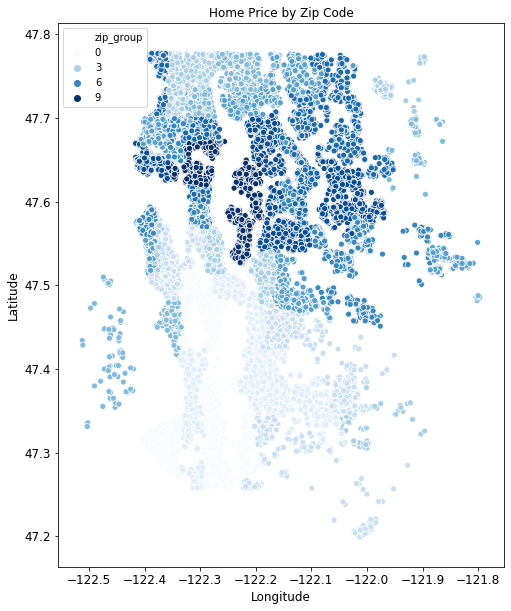

In [39]:
#Finalized version of the zip code map from earlier
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', hue='zip_group', data=new_df, palette='Blues')
plt.title('Home Price by Zip Code')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend(fancybox=True);
if export_check:
    plt.savefig('zip_map.png', dpi=300)

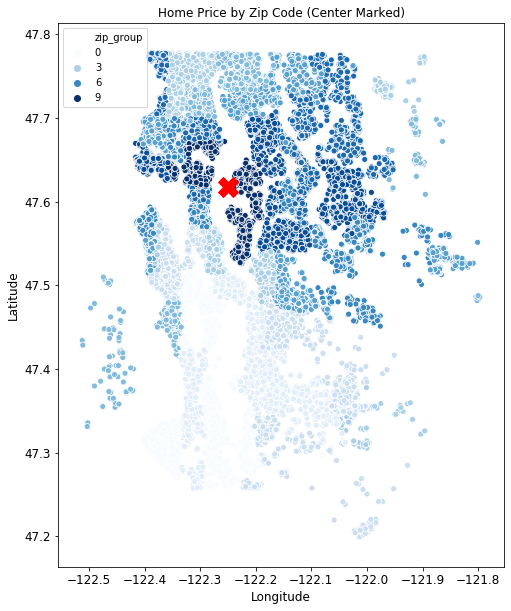

In [40]:
#Zip code map with the price epicenter marked in red. 
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', hue='zip_group', data=new_df, palette='Blues')
plt.plot(long_zero, lat_zero, 'rX', markersize=20)
plt.title('Home Price by Zip Code (Center Marked)')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend(fancybox=True);
if export_check:
    plt.savefig('zip_map_marked.png', dpi=300)

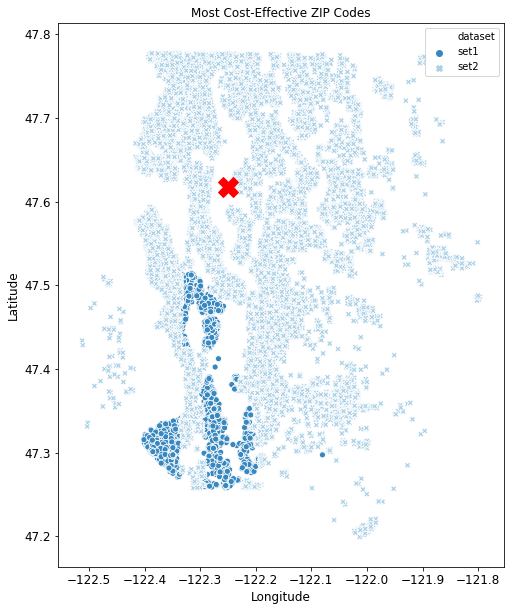

In [41]:
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', data=concatenated, hue='dataset', style='dataset', palette='Blues_r')
plt.title('Most Cost-Effective ZIP Codes')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.plot(long_zero, lat_zero, 'rX', markersize=20)
if export_check:
    plt.savefig('zero_map.png', dpi=300)

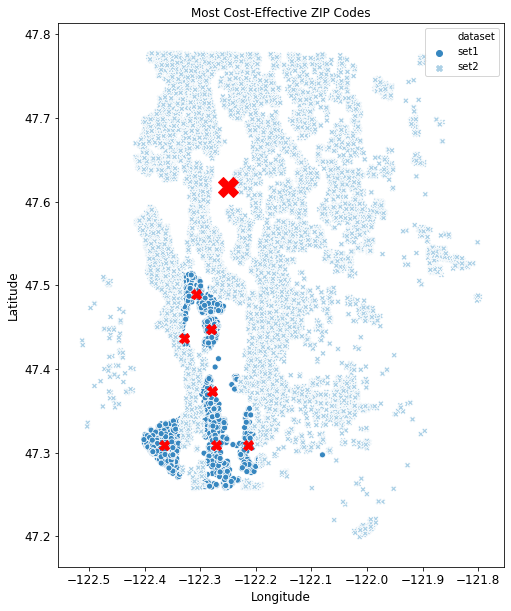

In [42]:
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', data=concatenated, hue='dataset', style='dataset', palette='Blues_r')
plt.title('Most Cost-Effective ZIP Codes')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.plot(grouped_subset['long'], grouped_subset['lat'], 'rX', markersize=10)
plt.plot(long_zero, lat_zero, 'rX', markersize=20)
if export_check:
    plt.savefig('zero_map_marked.png', dpi=300)

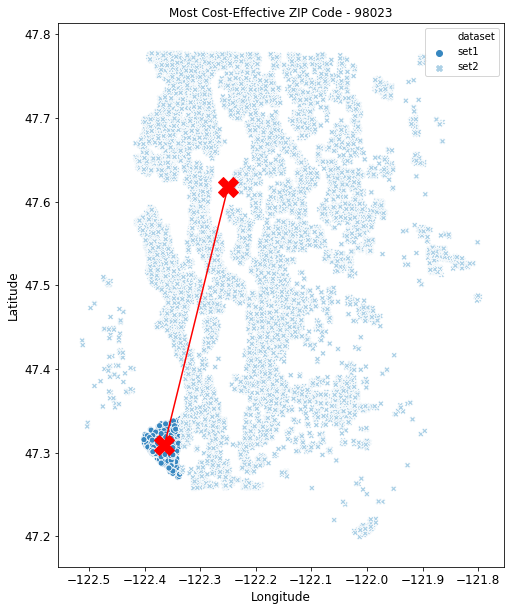

In [43]:
#Plotting the ZIP code with the best location according to my model
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', data=concatenated2, hue='dataset', style='dataset', palette='Blues_r')
plt.title('Most Cost-Effective ZIP Code - 98023')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.plot(grouped_subset.loc[98023, 'long'], \
         grouped_subset.loc[98023, 'lat'], 'rX', markersize=20)
plt.plot(long_zero, lat_zero, 'rX', markersize=20)
plt.plot([grouped_subset.loc[98023, 'long'], long_zero], \
         [grouped_subset.loc[98023, 'lat'], lat_zero], 'k-', color = 'r')
if export_check:
    plt.savefig('winner_map.png', dpi=300)

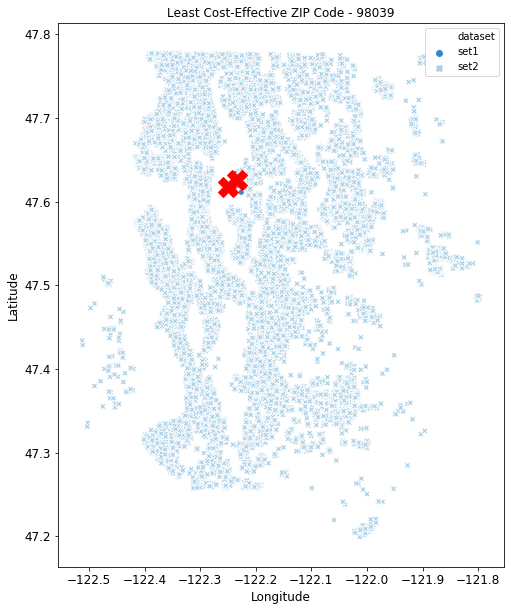

In [44]:
#Plotting the ZIP code with the least cost-effective location according to my model
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', data=concatenated3, hue='dataset', style='dataset', palette='Blues_r')
plt.title('Least Cost-Effective ZIP Code - 98039')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.plot(sorted_distance.loc[98039, 'long'], \
         sorted_distance.loc[98039, 'lat'], 'rX', markersize=20)
plt.plot(long_zero, lat_zero, 'rX', markersize=20)
plt.plot([sorted_distance.loc[98039, 'long'], long_zero], \
         [sorted_distance.loc[98039, 'lat'], lat_zero], 'k-', color = 'r')
if export_check:
    plt.savefig('loser_map.png', dpi=300)

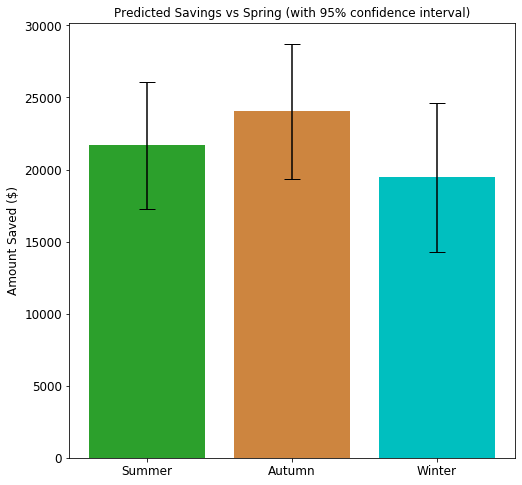

In [45]:
#Plotting the savings predicted when buying a home in any season besides Spring
plt.figure(figsize=(8,8))
plt.bar(Season_list, season_coefs, color=['tab:green','peru','c'])
plt.title("Predicted Savings vs Spring (with 95% confidence interval)")
plt.ylabel("Amount Saved ($)")
plt.errorbar(Season_list, season_coefs, yerr=season_intervals, xerr=None, ls='', capsize=8, color='k')
if export_check:
    plt.savefig('season_savings.png', dpi=300)

# Conclusions and Answers
With all of the coding and graphs complete I can now address the questions that I originally set out to answer.  

> - What is the most cost-effective location in King County?

According to the model, the most cost-effective location is the 98023 ZIP code.  This ZIP code had the lowest cost associated with it's geographic location, and is predicted to be $141602 less expensive than the baseline model.  This is where I would recommend purchasing a home for a buyer trying to minimize costs.  

> - How much money can be saved based solely on location?

Quite a bit!  The difference between the geographic costs in the 98023 ZIP code (the lowest) and the 98039 ZIP code (the highest) was $466857.  This means that all else being equal, the model predicts that this cost difference is entirely derived from location.  Due to the much higher price associated with the 98039 ZIP code, I would recommend not purchasing a home there if cost-effectiveness is the goal.  

> - Are there any other savings opportunities hidden in the data? 

Yes, and it is an easy factor for a home buyer to control.  The model predicts that Spring is the most expensive season to buy a home, and one simple way to lower costs is to buy during a different season.  Specifically, I would recommend Autumn.  This is the season with the highest predicted savings compared to Spring, coming in at approximately $24000. 